In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type

In [2]:
X_train = np.load("/Users/somiseta/isic2018/221_221/221_221_train.npy")

In [3]:
y_train = np.load("/Users/somiseta/isic2018/221_221/train_labels.npy")

In [4]:
X_val = np.load("/Users/somiseta/isic2018/221_221/221_221_val.npy")

In [5]:
y_val = np.load("/Users/somiseta/isic2018/221_221/val_labels.npy")

In [6]:
X_train.shape, X_val.shape

((8111, 221, 221, 3), (902, 221, 221, 3))

In [7]:
y_train.shape, y_val.shape

((8111,), (902,))

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [9]:
pre_trained_model = InceptionV3(input_shape=(221, 221, 3), include_top=False, weights="imagenet")

In [10]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
max_pooling2d_2
conv2d_9
batch_normalization_9
activation_9
conv2d_7
conv2d_10
batch_normalization_7
batch_normalization_10
activation_7
activation_10
average_pooling2d_1
conv2d_6
conv2d_8
conv2d_11
conv2d_12
batch_normalization_6
batch_normalization_8
batch_normalization_11
batch_normalization_12
activation_6
activation_8
activation_11
activation_12
mixed0
conv2d_16
batch_normalization_16
activation_16
conv2d_14
conv2d_17
batch_normalization_14
batch_normalization_17
activation_14
activation_17
average_pooling2d_2
conv2d_13
conv2d_15
conv2d_18
conv2d_19
batch_normalization_13
batch_normalization_15
batch_normalization_18
batch_normalization_19
activation_13
activation_15
activation_18
activation_19
mixed1
conv2d_23
batch_normalization_23
activat

In [11]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 5, 5, 2048)


In [12]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
#Fully connected layer with 512 hidden units with RELU activation function
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configuring and Compiling the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 221, 221, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 110, 110, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 110, 110, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 110, 110, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [15]:
batch_size = 64
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

Epoch 1/3
126/126 [==============================] - 89s 702ms/step - loss: 1.5354 - acc: 0.5970 - val_loss: 0.9946 - val_acc: 0.7098
Epoch 2/3
126/126 [==============================] - 74s 585ms/step - loss: 1.0893 - acc: 0.6622 - val_loss: 0.9546 - val_acc: 0.7098
Epoch 3/3
126/126 [==============================] - 73s 580ms/step - loss: 1.0250 - acc: 0.6709 - val_loss: 0.8962 - val_acc: 0.7165


In [16]:
for layer in pre_trained_model.layers[249:]:
    layer.trainable = True

In [17]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 221, 221, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 110, 110, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 110, 110, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 110, 110, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
batch_size = 64
epochs = 35
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/35
126/126 [==============================] - 84s 669ms/step - loss: 0.9335 - acc: 0.6883 - val_loss: 0.9334 - val_acc: 0.6629
Epoch 2/35
126/126 [==============================] - 74s 589ms/step - loss: 0.7828 - acc: 0.7249 - val_loss: 0.8457 - val_acc: 0.6964
Epoch 3/35
126/126 [==============================] - 74s 586ms/step - loss: 0.7318 - acc: 0.7391 - val_loss: 0.7488 - val_acc: 0.7366
Epoch 4/35
126/126 [==============================] - 73s 583ms/step - loss: 0.6648 - acc: 0.7623 - val_loss: 0.7374 - val_acc: 0.7500
Epoch 5/35
126/126 [==============================] - 73s 582ms/step - loss: 0.6333 - acc: 0.7743 - val_loss: 0.7271 - val_acc: 0.7388
Epoch 6/35
126/126 [==============================] - 73s 578ms/step - loss: 0.6001 - acc: 0.7890 - val_loss: 0.7534 - val_acc: 0.7299
Epoch 7/35
126/126 [==============================] - 73s 583ms/step - loss: 0.5659 - acc: 0.7944 - val_loss: 0.7203 - val_acc: 0.7522
Epoch 8/35
126/126 [==============================] - 7

In [21]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

902/902 [==============================] - 3s 4ms/step
Validation: accuracy = 0.805987  ;  loss_v = 0.674443


In [23]:
X_test = np.load("/Users/somiseta/isic2018/221_221/221_221_test.npy")

In [24]:
y_test = np.load("/Users/somiseta/isic2018/221_221/test_labels.npy")
y_test = to_categorical(y_test)

In [26]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

1002/1002 [==============================] - 3s 3ms/step
Test: accuracy = 0.823353  ;  loss = 0.710989


In [27]:
model.save("InceptionV3.h5")

<Figure size 432x288 with 0 Axes>

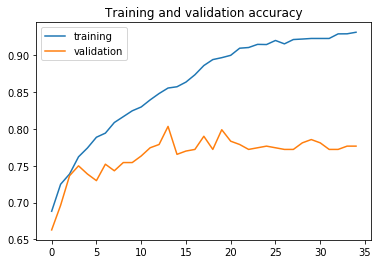

<Figure size 432x288 with 0 Axes>

In [28]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']


# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()


Text(0.5, 1.0, 'Training and validation loss')

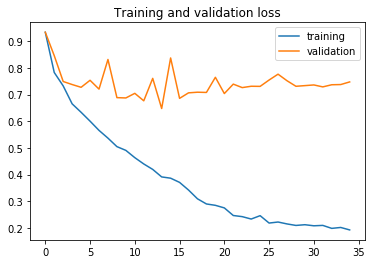

In [29]:

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
# Plot training and validation loss per epoch

plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')